['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Epoch 1, Loss: 1.4574, Accuracy: 59.03%
Epoch 2, Loss: 1.0425, Accuracy: 60.63%
Epoch 3, Loss: 0.8564, Accuracy: 69.06%
Epoch 4, Loss: 0.7089, Accuracy: 71.31%
Epoch 5, Loss: 0.5780, Accuracy: 71.31%
Epoch 6, Loss: 0.4433, Accuracy: 72.28%
Epoch 7, Loss: 0.3153, Accuracy: 72.54%
Epoch 8, Loss: 0.2205, Accuracy: 72.04%
Epoch 9, Loss: 0.1524, Accuracy: 71.02%
Epoch 10, Loss: 0.1106, Accuracy: 71.13%
Epoch 11, Loss: 0.0976, Accuracy: 70.94%
Epoch 12, Loss: 0.0843, Accuracy: 70.63%
Epoch 13, Loss: 0.0812, Accuracy: 71.17%
Epoch 14, Loss: 0.0695, Accuracy: 70.99%
Epoch 15, Loss: 0.0631, Accuracy: 70.01%
Epoch 16, Loss: 0.0594, Accuracy: 71.19%
Epoch 17, Loss: 0.0636, Accuracy: 70.66%
Epoch 18, Loss: 0.0531, Accuracy: 70.29%
Epoch 19, Loss: 0.0536, Accuracy: 71.37%
Epoch 20, Loss: 0.0583, Accuracy: 71.29%
Epoch 21, Loss: 0.0540, Accuracy: 70.12%
Epoch 22, Loss: 0.0499, Accuracy: 70.13%
Epoch 23, Loss: 

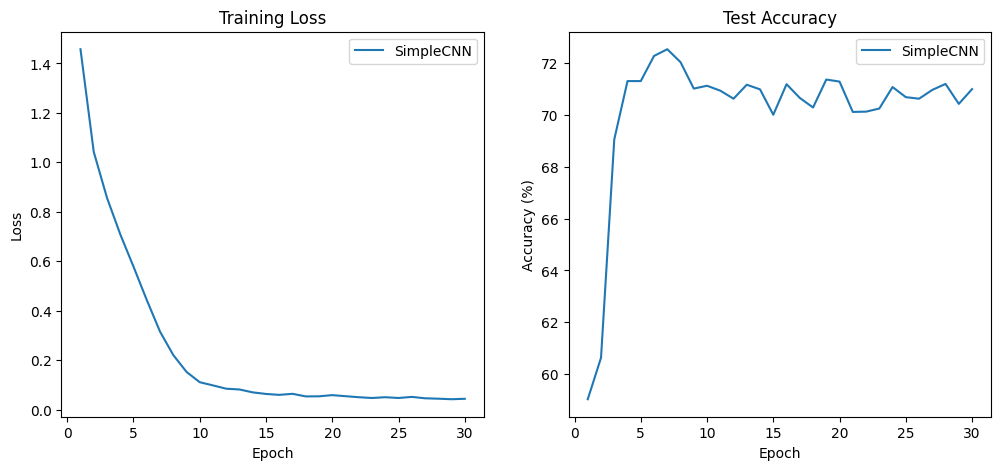

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 设备设置：GPU 如果可用，否则使用 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据转化为Tensor类型
transform = transforms.Compose(
    [transforms.ToTensor()]
)

# 加载数据集
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

# 分批次加载，每次训练时加载64张图片，shuffle=True表示训练时打乱数据
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
classes = trainloader.dataset.classes
print(classes)
print(classes == ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])

# 简单的卷积神经网络模型定义
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 第一个卷积层：输入3通道，输出32通道，卷积核大小3x3，步长1，填充1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # 全连接层
        self.fc2 = nn.Linear(512, 10)  # 输出层，10个类别
        self.pool = nn.MaxPool2d(2, 2)  # 2x2最大池化
    def forward(self, x):
        # 通过卷积层并激活
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        
        # 展平操作
        x = x.view(-1, 128 * 8 * 8)  # 128通道，每次池化大小减半，32->16->8
        
        # 全连接层
        x = torch.relu(self.fc1(x))
        # 在PyTorch中，CrossEntropyLoss会自动对输出进行 softmax 计算，因此不需要显式地在输出层添加 softmax
        x = self.fc2(x) 
        return x

# 实例化模型并转移到GPU
model = SimpleCNN().to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练函数
def train_model(model, epochs=30):
    model.to(device)
    train_losses, test_accuracies = [], []
    
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # 清除前一梯度
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        
        # 测试阶段
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    return train_losses, test_accuracies

# 存储训练结果
all_train_losses = []
all_test_accuracies = []

# 训练模型
train_losses, test_accuracies = train_model(model)
all_train_losses.append(train_losses)
all_test_accuracies.append(test_accuracies)

plt.figure(figsize=(12, 5))

# 绘制训练损失
plt.subplot(1, 2, 1)
plt.plot(range(1, 31), train_losses, label="SimpleCNN")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 绘制测试准确率
plt.subplot(1, 2, 2)
plt.plot(range(1, 31), test_accuracies, label="SimpleCNN")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()